# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install torchvision==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.7 MB/s eta 0:00:00
Reason for being yanked: So that users won't accidentally install this when using python 3.11
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.12 requires torchvision>=0.8.2, but you have torchvision 0.2.1 which is incompatible.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), 11.01 MiB | 1.45 MiB/s, done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

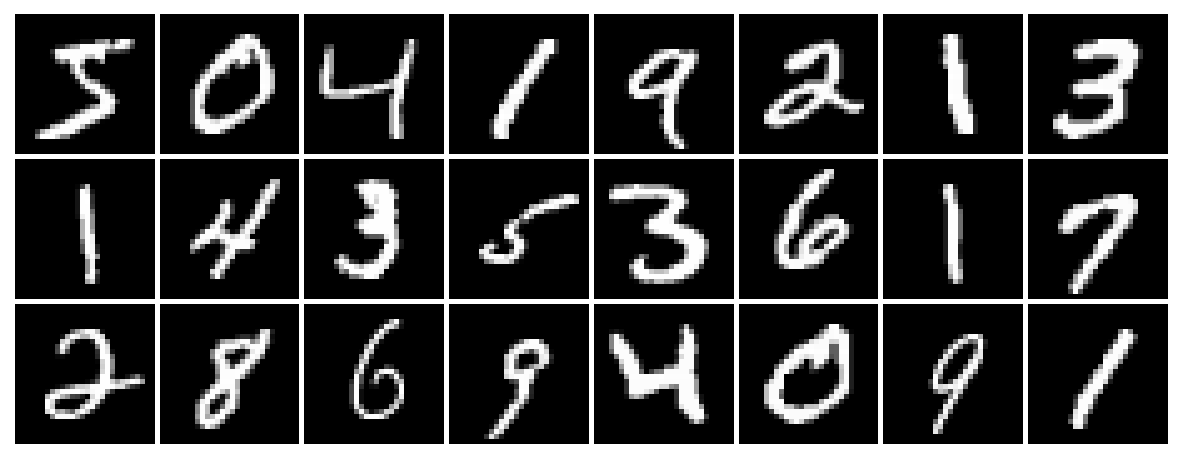

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(9)


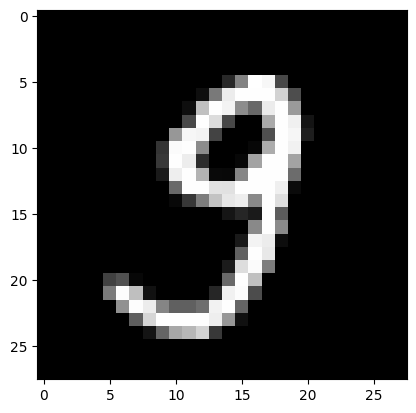

In [10]:
image  = x_train[346]
target = y_train[346]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [11]:
28*28

784

In [59]:
model = torch.nn.Linear(784, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [54]:
xin = x_train[:5].view(-1,28*28)
xin

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [55]:
score = model(Variable(xin))
score

tensor([[-0.0046,  0.0162, -0.2935, -0.0016, -0.0990, -0.2127,  0.0913, -0.4839,
          0.2101,  0.1843],
        [ 0.3787, -0.5136, -0.1591, -0.2003,  0.6348, -0.1340,  0.0046, -0.1205,
          0.1980,  0.0667],
        [-0.1485,  0.0063, -0.0734,  0.0243, -0.0061,  0.1088, -0.0177, -0.0682,
          0.0913, -0.1422],
        [ 0.0703, -0.1014,  0.1452,  0.1012, -0.1541, -0.0529, -0.0143, -0.1079,
          0.0777,  0.2853],
        [ 0.2397, -0.3189,  0.1489, -0.1234,  0.1739,  0.0318, -0.0838, -0.0795,
          0.0979, -0.2034]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [60]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [47]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-xltwcsg9
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-xltwcsg9
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


In [57]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss
# p = make_dot(loss, dict(model.named_parameters()))
# p

tensor(2.3229, grad_fn=<NllLossBackward0>)

### Laço de treinamento dos pesos

Epoch 1
Accuracy: 0.064
Losses: tensor(2.3442, grad_fn=<NllLossBackward0>)


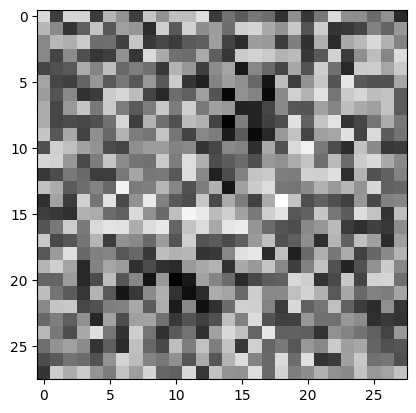

Epoch 2
Accuracy: 0.641
Losses: tensor(1.8284, grad_fn=<NllLossBackward0>)


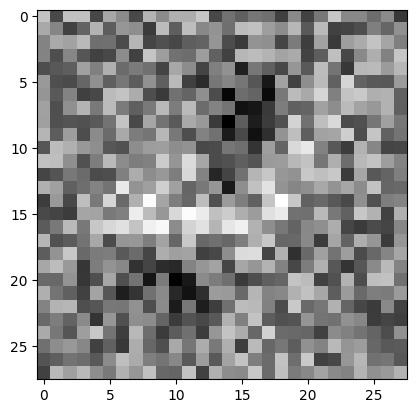

Epoch 3
Accuracy: 0.757
Losses: tensor(1.4862, grad_fn=<NllLossBackward0>)


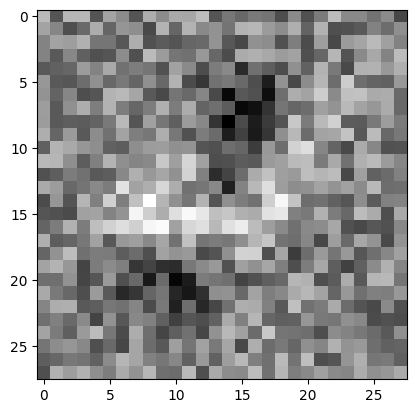

Epoch 4
Accuracy: 0.771
Losses: tensor(1.2586, grad_fn=<NllLossBackward0>)


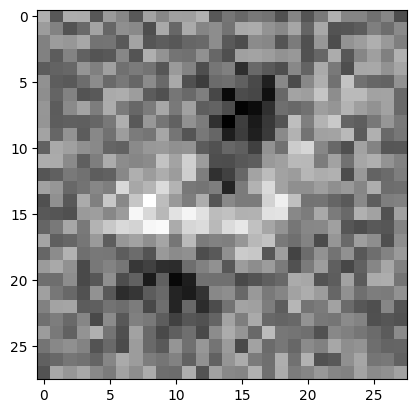

Epoch 5
Accuracy: 0.808
Losses: tensor(1.1053, grad_fn=<NllLossBackward0>)


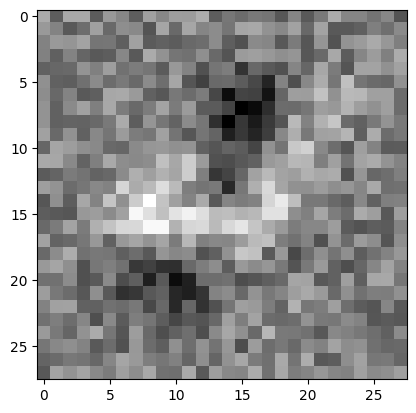

Epoch 6
Accuracy: 0.809
Losses: tensor(0.9938, grad_fn=<NllLossBackward0>)


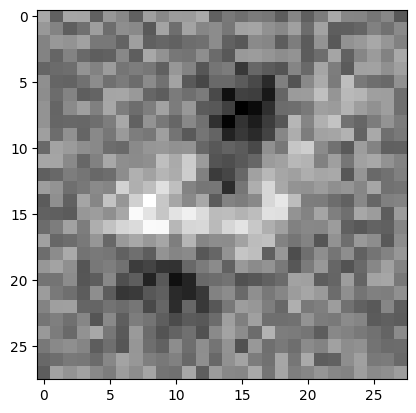

Epoch 7
Accuracy: 0.828
Losses: tensor(0.9119, grad_fn=<NllLossBackward0>)


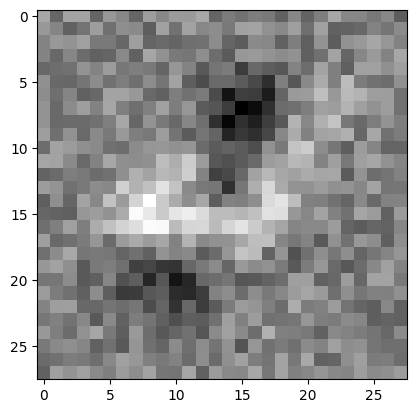

Epoch 8
Accuracy: 0.829
Losses: tensor(0.8487, grad_fn=<NllLossBackward0>)


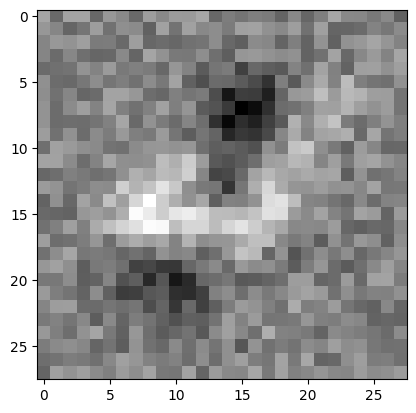

Epoch 9
Accuracy: 0.838
Losses: tensor(0.7981, grad_fn=<NllLossBackward0>)


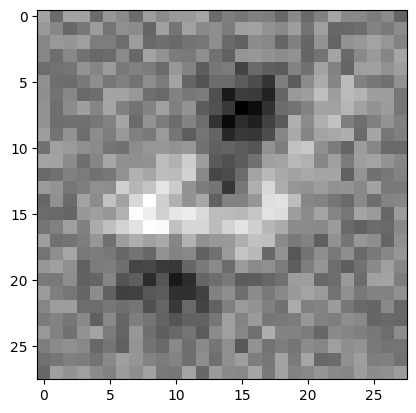

Epoch 10
Accuracy: 0.841
Losses: tensor(0.7564, grad_fn=<NllLossBackward0>)


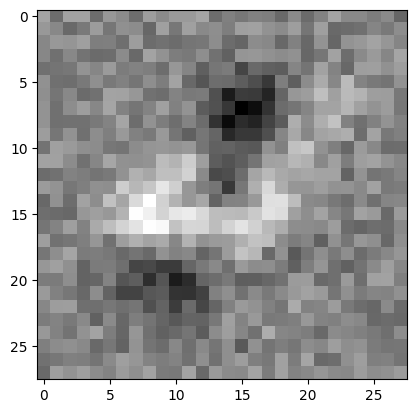

Epoch 11
Accuracy: 0.854
Losses: tensor(0.7214, grad_fn=<NllLossBackward0>)


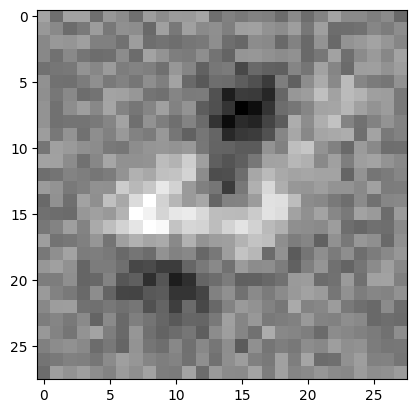

Epoch 12
Accuracy: 0.857
Losses: tensor(0.6914, grad_fn=<NllLossBackward0>)


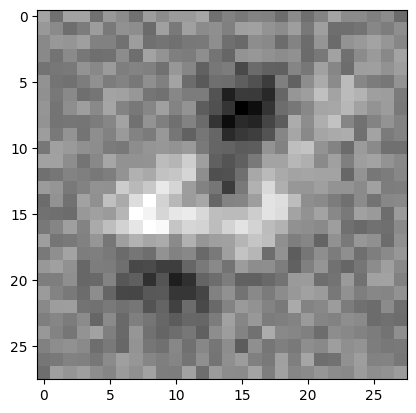

Epoch 13
Accuracy: 0.861
Losses: tensor(0.6653, grad_fn=<NllLossBackward0>)


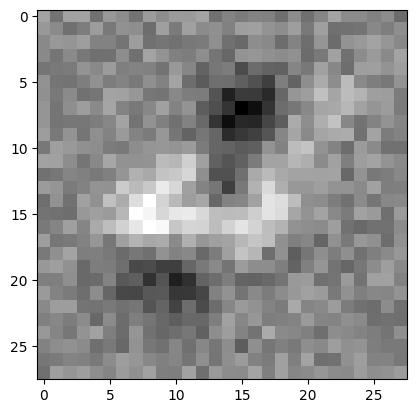

Epoch 14
Accuracy: 0.862
Losses: tensor(0.6424, grad_fn=<NllLossBackward0>)


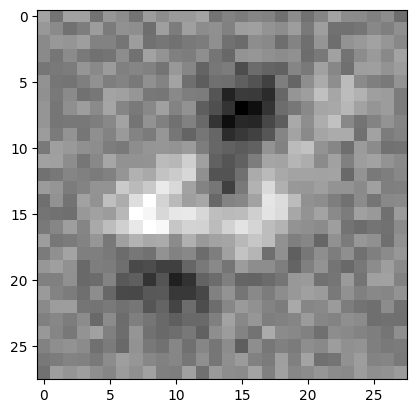

Epoch 15
Accuracy: 0.862
Losses: tensor(0.6220, grad_fn=<NllLossBackward0>)


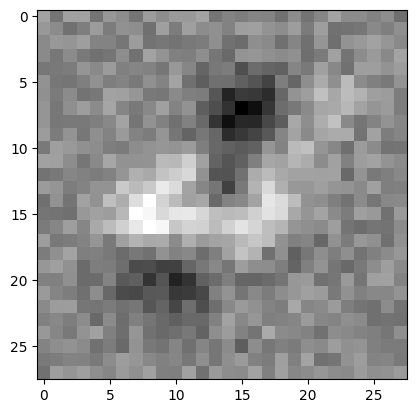

Epoch 16
Accuracy: 0.867
Losses: tensor(0.6037, grad_fn=<NllLossBackward0>)


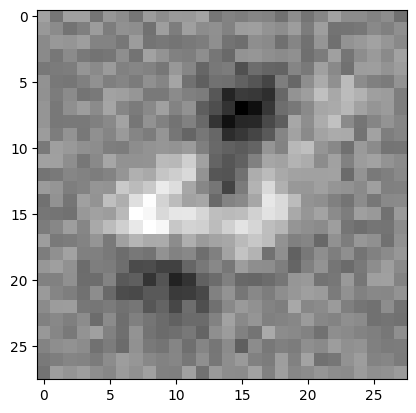

Epoch 17
Accuracy: 0.867
Losses: tensor(0.5872, grad_fn=<NllLossBackward0>)


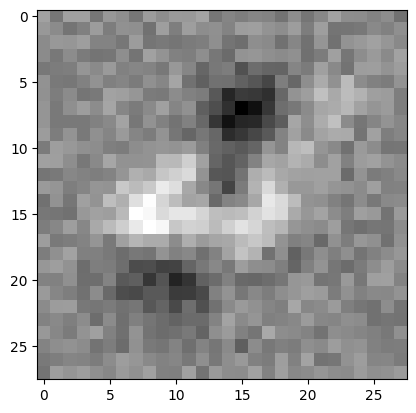

Epoch 18
Accuracy: 0.87
Losses: tensor(0.5722, grad_fn=<NllLossBackward0>)


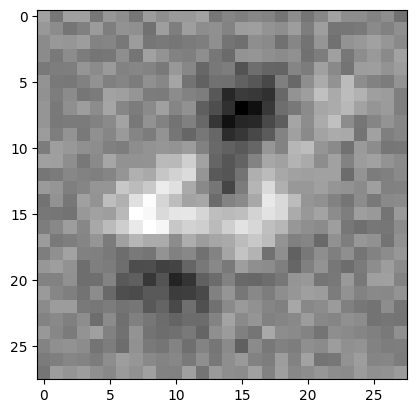

Epoch 19
Accuracy: 0.874
Losses: tensor(0.5585, grad_fn=<NllLossBackward0>)


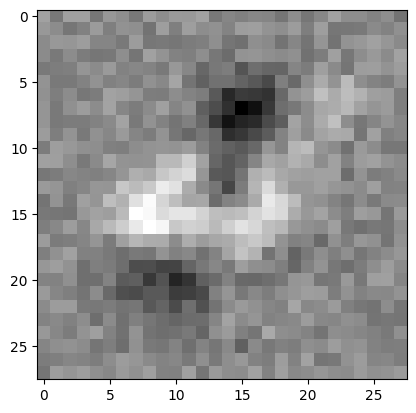

Epoch 20
Accuracy: 0.875
Losses: tensor(0.5458, grad_fn=<NllLossBackward0>)


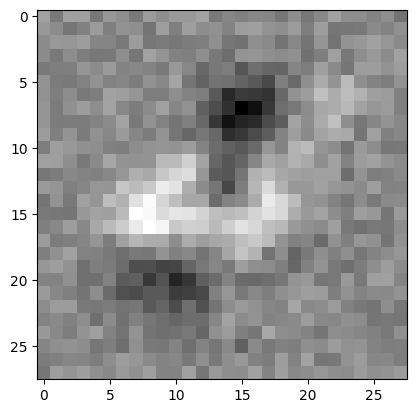

Epoch 21
Accuracy: 0.877
Losses: tensor(0.5341, grad_fn=<NllLossBackward0>)


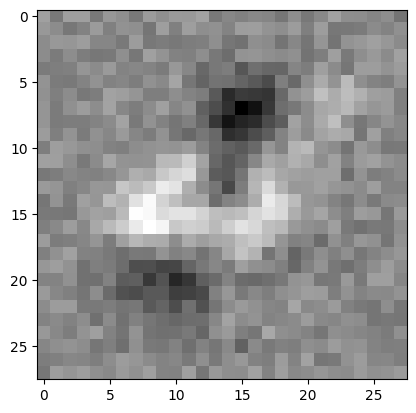

Epoch 22
Accuracy: 0.881
Losses: tensor(0.5232, grad_fn=<NllLossBackward0>)


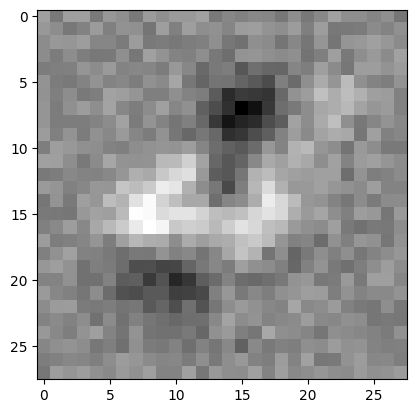

Epoch 23
Accuracy: 0.885
Losses: tensor(0.5131, grad_fn=<NllLossBackward0>)


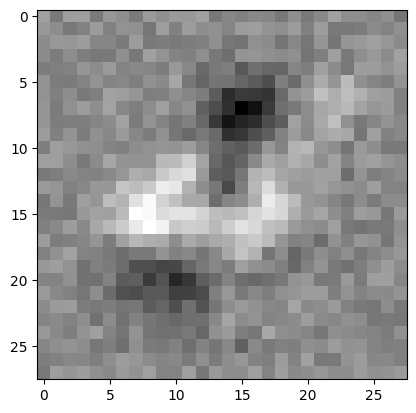

Epoch 24
Accuracy: 0.885
Losses: tensor(0.5036, grad_fn=<NllLossBackward0>)


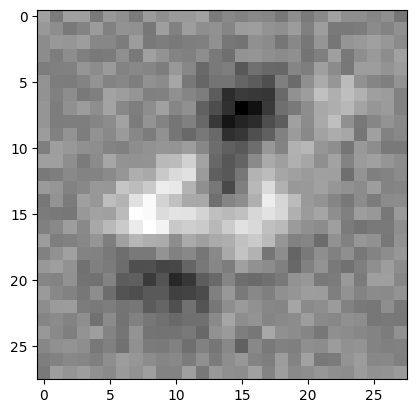

Epoch 25
Accuracy: 0.886
Losses: tensor(0.4947, grad_fn=<NllLossBackward0>)


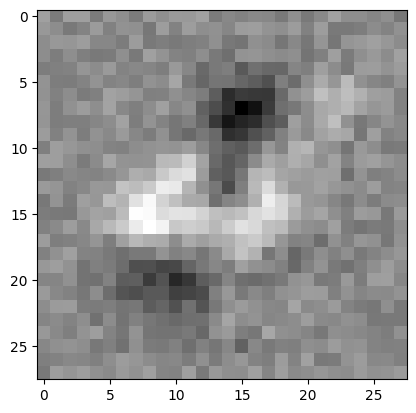

Epoch 26
Accuracy: 0.886
Losses: tensor(0.4863, grad_fn=<NllLossBackward0>)


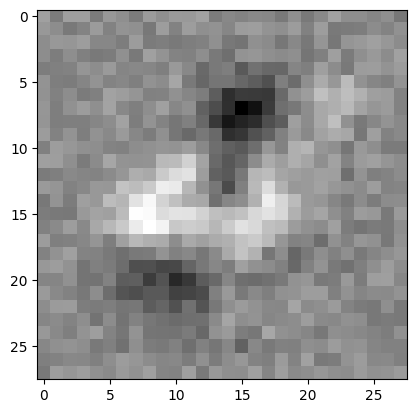

Epoch 27
Accuracy: 0.89
Losses: tensor(0.4784, grad_fn=<NllLossBackward0>)


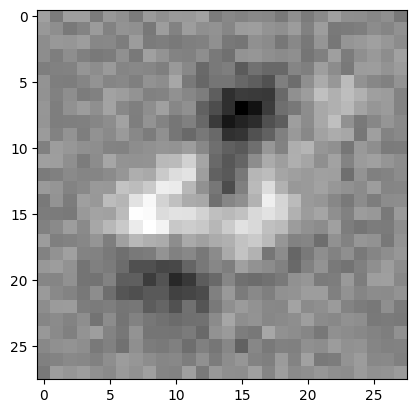

Epoch 28
Accuracy: 0.891
Losses: tensor(0.4709, grad_fn=<NllLossBackward0>)


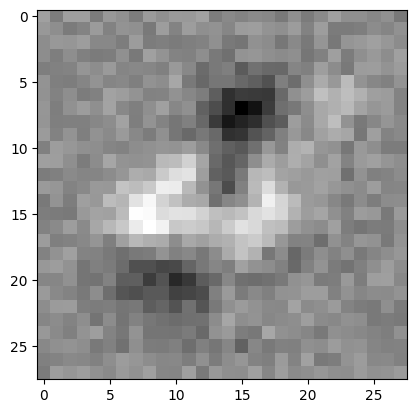

Epoch 29
Accuracy: 0.892
Losses: tensor(0.4639, grad_fn=<NllLossBackward0>)


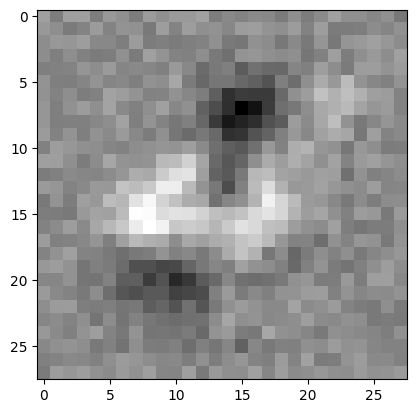

Epoch 30
Accuracy: 0.895
Losses: tensor(0.4571, grad_fn=<NllLossBackward0>)


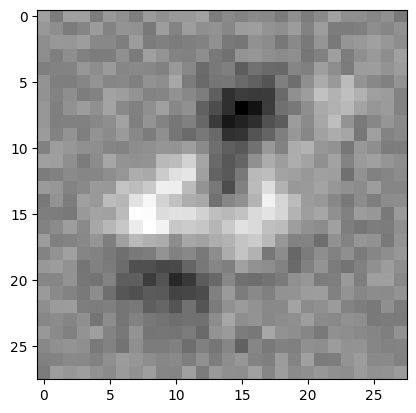

Epoch 31
Accuracy: 0.897
Losses: tensor(0.4507, grad_fn=<NllLossBackward0>)


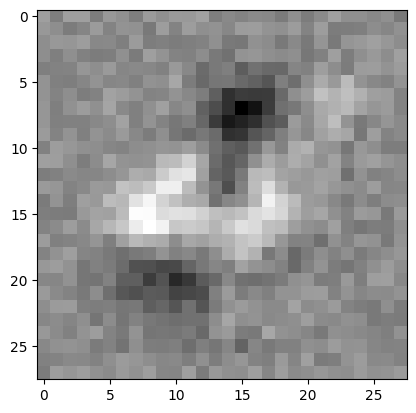

Epoch 32
Accuracy: 0.898
Losses: tensor(0.4446, grad_fn=<NllLossBackward0>)


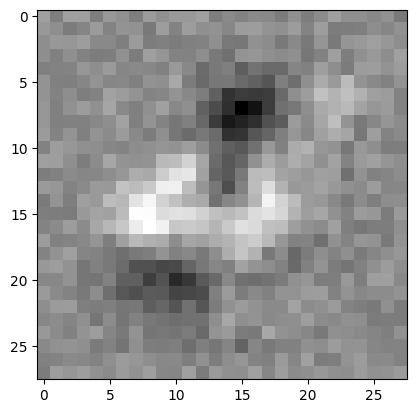

Epoch 33
Accuracy: 0.899
Losses: tensor(0.4387, grad_fn=<NllLossBackward0>)


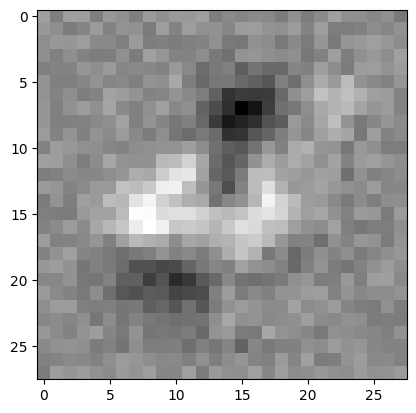

Epoch 34
Accuracy: 0.902
Losses: tensor(0.4331, grad_fn=<NllLossBackward0>)


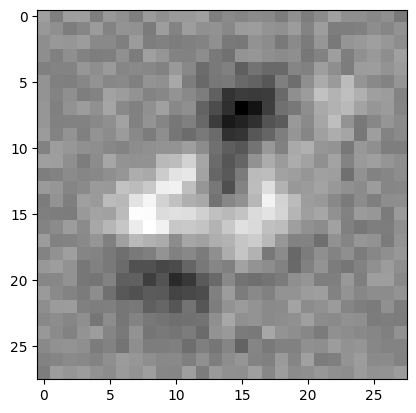

Epoch 35
Accuracy: 0.902
Losses: tensor(0.4277, grad_fn=<NllLossBackward0>)


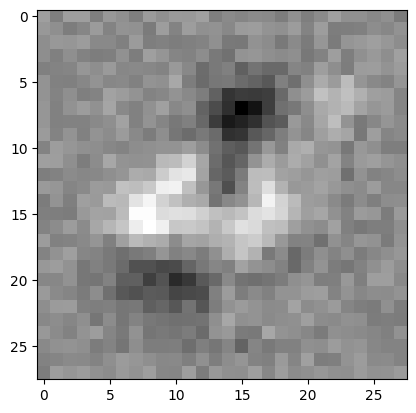

Epoch 36
Accuracy: 0.903
Losses: tensor(0.4226, grad_fn=<NllLossBackward0>)


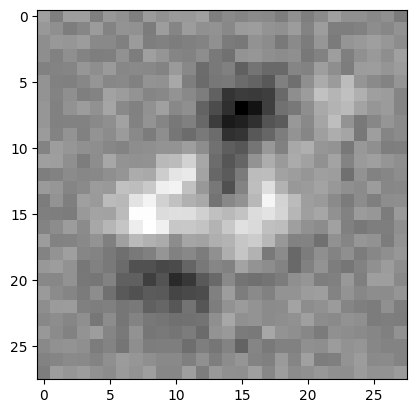

Epoch 37
Accuracy: 0.904
Losses: tensor(0.4176, grad_fn=<NllLossBackward0>)


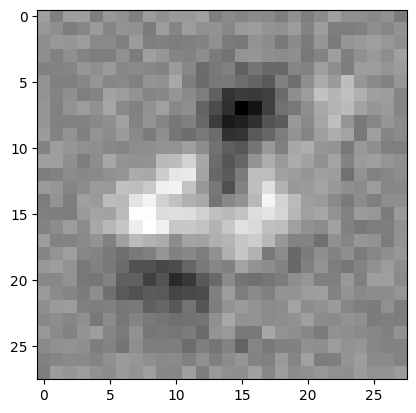

Epoch 38
Accuracy: 0.905
Losses: tensor(0.4128, grad_fn=<NllLossBackward0>)


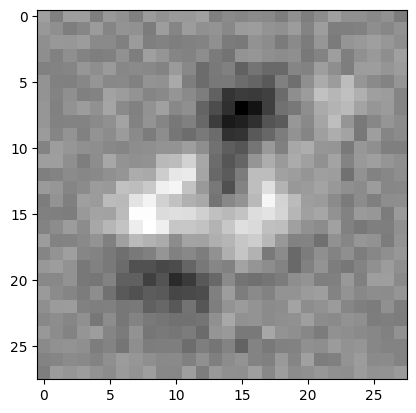

Epoch 39
Accuracy: 0.906
Losses: tensor(0.4082, grad_fn=<NllLossBackward0>)


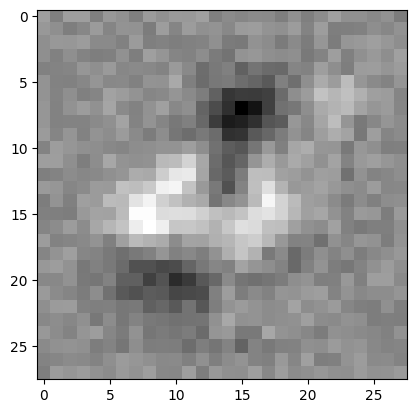

Epoch 40
Accuracy: 0.908
Losses: tensor(0.4038, grad_fn=<NllLossBackward0>)


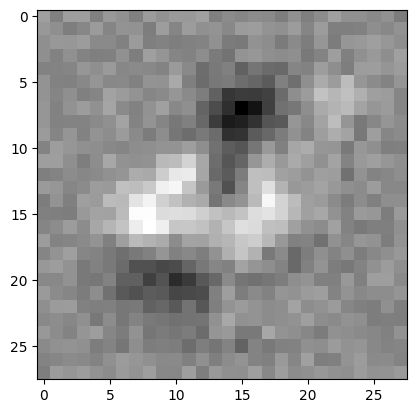

Epoch 41
Accuracy: 0.908
Losses: tensor(0.3995, grad_fn=<NllLossBackward0>)


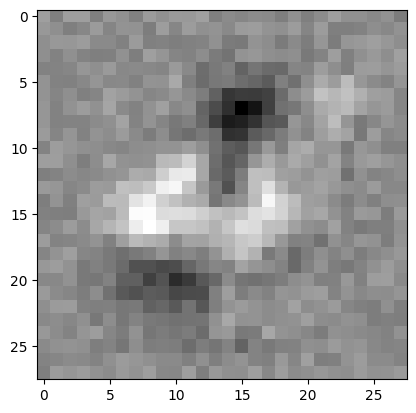

Epoch 42
Accuracy: 0.908
Losses: tensor(0.3954, grad_fn=<NllLossBackward0>)


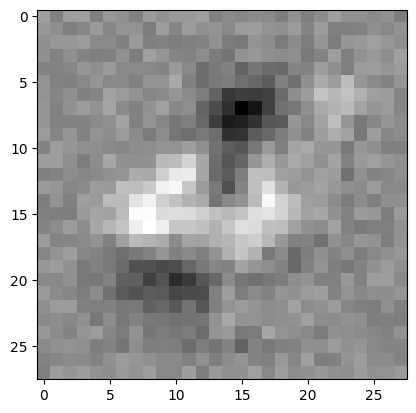

Epoch 43
Accuracy: 0.908
Losses: tensor(0.3913, grad_fn=<NllLossBackward0>)


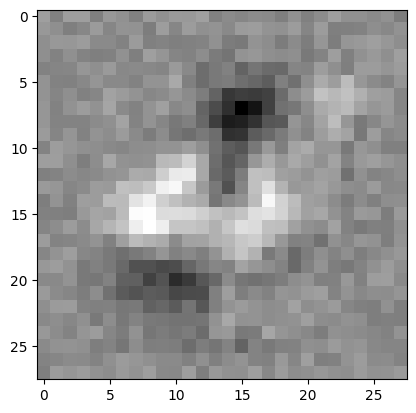

Epoch 44
Accuracy: 0.908
Losses: tensor(0.3875, grad_fn=<NllLossBackward0>)


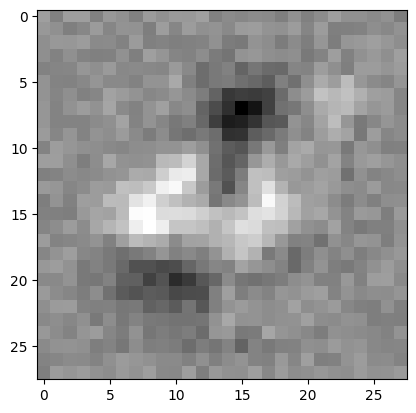

Epoch 45
Accuracy: 0.912
Losses: tensor(0.3837, grad_fn=<NllLossBackward0>)


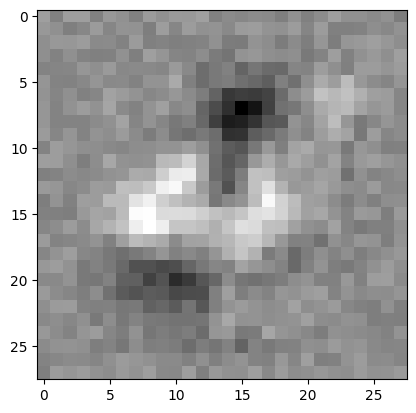

Epoch 46
Accuracy: 0.912
Losses: tensor(0.3800, grad_fn=<NllLossBackward0>)


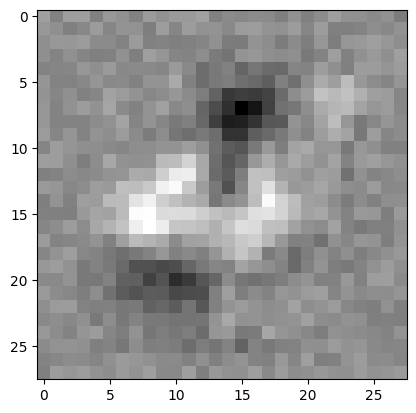

Epoch 47
Accuracy: 0.912
Losses: tensor(0.3765, grad_fn=<NllLossBackward0>)


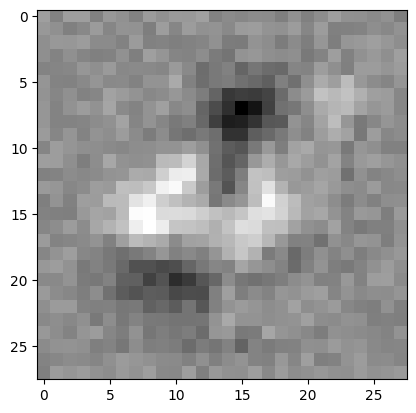

Epoch 48
Accuracy: 0.915
Losses: tensor(0.3730, grad_fn=<NllLossBackward0>)


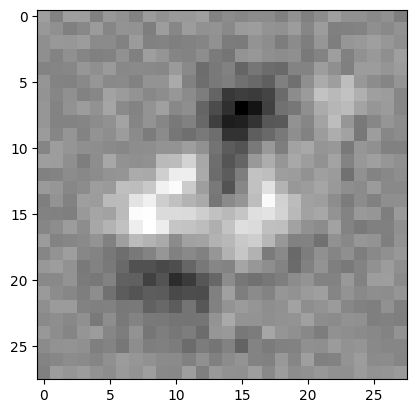

Epoch 49
Accuracy: 0.919
Losses: tensor(0.3697, grad_fn=<NllLossBackward0>)


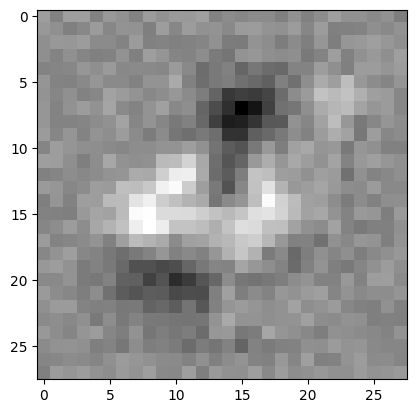

Epoch 50
Accuracy: 0.919
Losses: tensor(0.3664, grad_fn=<NllLossBackward0>)


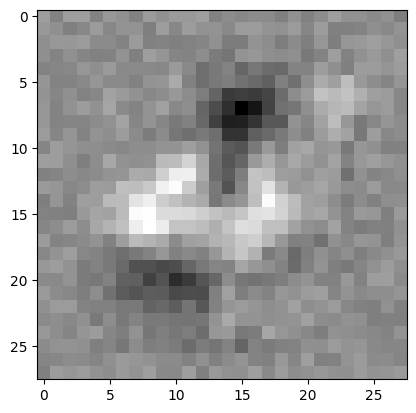

Epoch 51
Accuracy: 0.919
Losses: tensor(0.3633, grad_fn=<NllLossBackward0>)


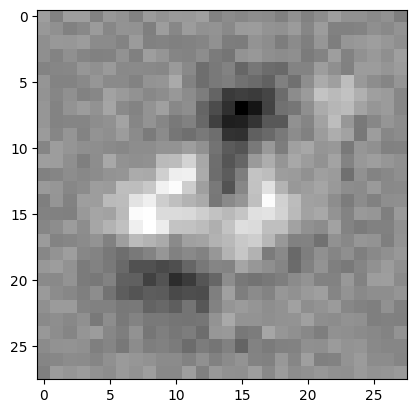

Epoch 52
Accuracy: 0.919
Losses: tensor(0.3602, grad_fn=<NllLossBackward0>)


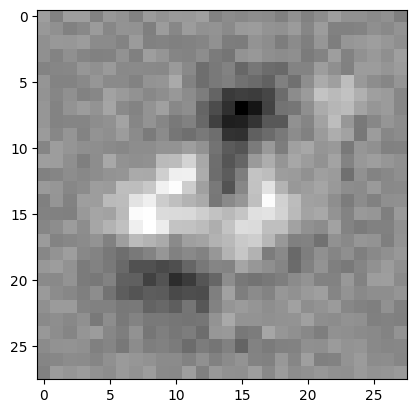

Epoch 53
Accuracy: 0.92
Losses: tensor(0.3572, grad_fn=<NllLossBackward0>)


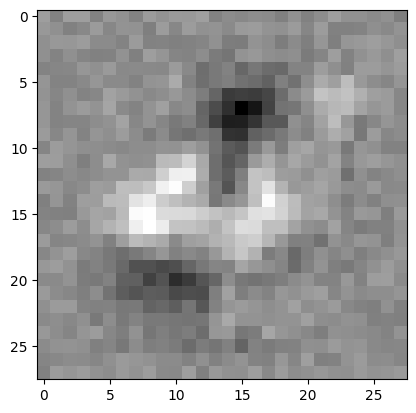

Epoch 54
Accuracy: 0.92
Losses: tensor(0.3542, grad_fn=<NllLossBackward0>)


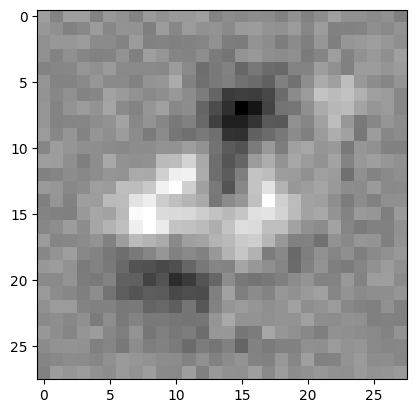

Epoch 55
Accuracy: 0.921
Losses: tensor(0.3513, grad_fn=<NllLossBackward0>)


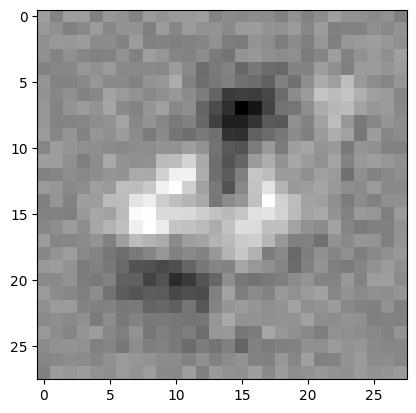

Epoch 56
Accuracy: 0.921
Losses: tensor(0.3485, grad_fn=<NllLossBackward0>)


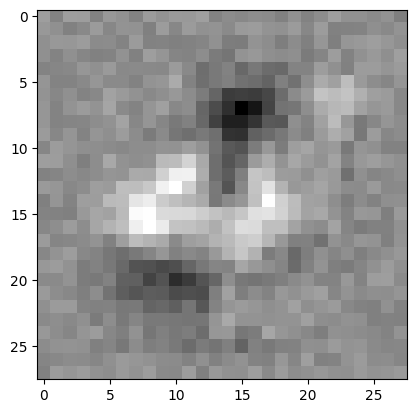

Epoch 57
Accuracy: 0.922
Losses: tensor(0.3458, grad_fn=<NllLossBackward0>)


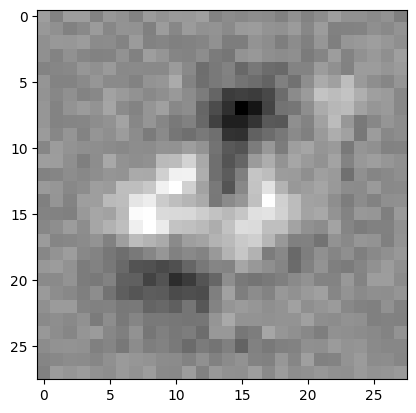

Epoch 58
Accuracy: 0.924
Losses: tensor(0.3431, grad_fn=<NllLossBackward0>)


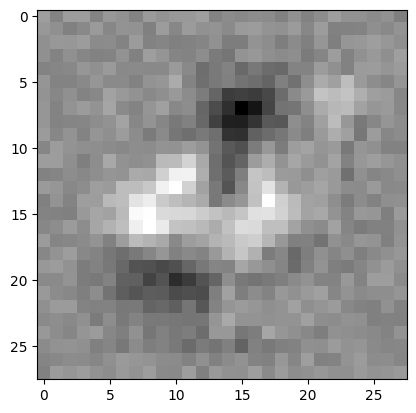

Epoch 59
Accuracy: 0.924
Losses: tensor(0.3405, grad_fn=<NllLossBackward0>)


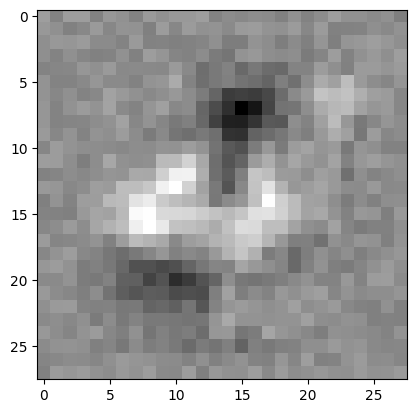

Epoch 60
Accuracy: 0.923
Losses: tensor(0.3380, grad_fn=<NllLossBackward0>)


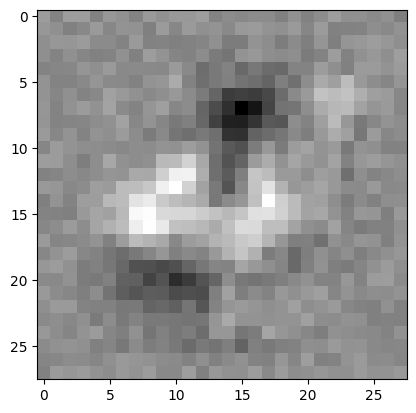

Epoch 61
Accuracy: 0.924
Losses: tensor(0.3354, grad_fn=<NllLossBackward0>)


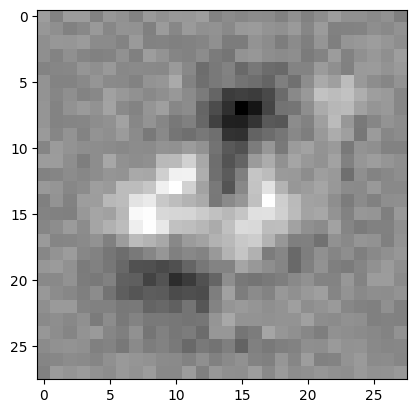

Epoch 62
Accuracy: 0.924
Losses: tensor(0.3330, grad_fn=<NllLossBackward0>)


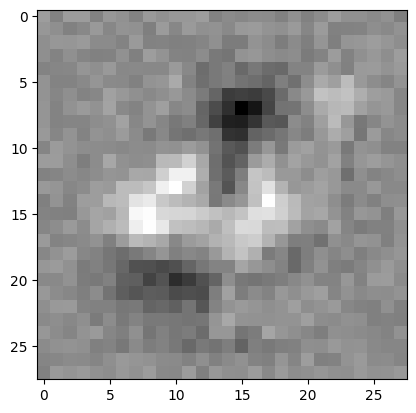

Epoch 63
Accuracy: 0.925
Losses: tensor(0.3306, grad_fn=<NllLossBackward0>)


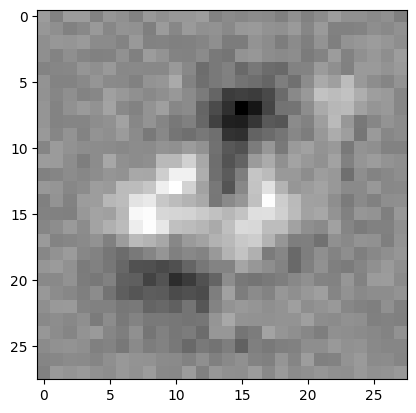

Epoch 64
Accuracy: 0.926
Losses: tensor(0.3282, grad_fn=<NllLossBackward0>)


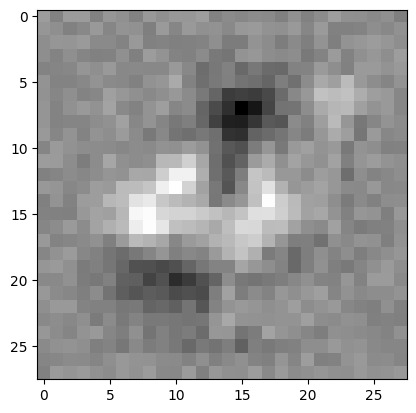

Epoch 65
Accuracy: 0.926
Losses: tensor(0.3259, grad_fn=<NllLossBackward0>)


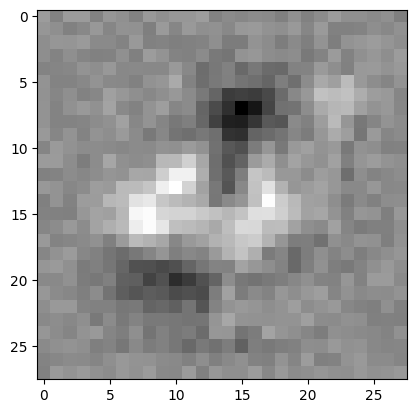

Epoch 66
Accuracy: 0.926
Losses: tensor(0.3237, grad_fn=<NllLossBackward0>)


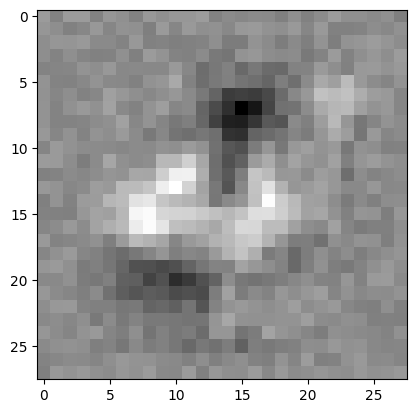

Epoch 67
Accuracy: 0.928
Losses: tensor(0.3215, grad_fn=<NllLossBackward0>)


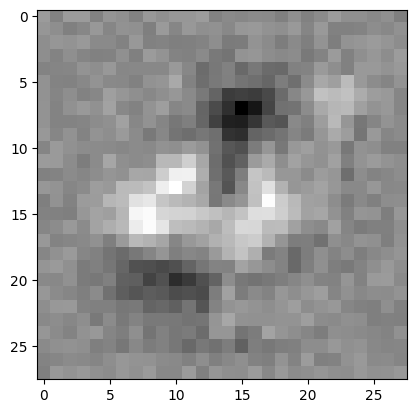

Epoch 68
Accuracy: 0.928
Losses: tensor(0.3193, grad_fn=<NllLossBackward0>)


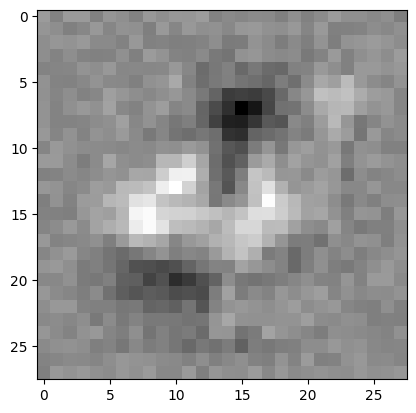

Epoch 69
Accuracy: 0.928
Losses: tensor(0.3171, grad_fn=<NllLossBackward0>)


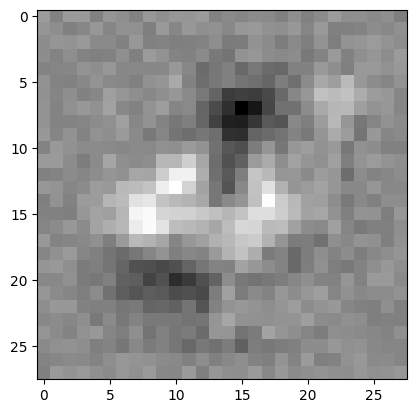

Epoch 70
Accuracy: 0.929
Losses: tensor(0.3150, grad_fn=<NllLossBackward0>)


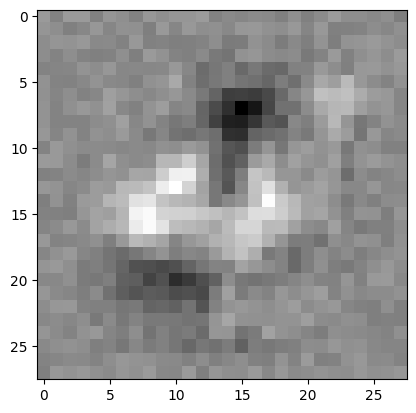

Epoch 71
Accuracy: 0.929
Losses: tensor(0.3130, grad_fn=<NllLossBackward0>)


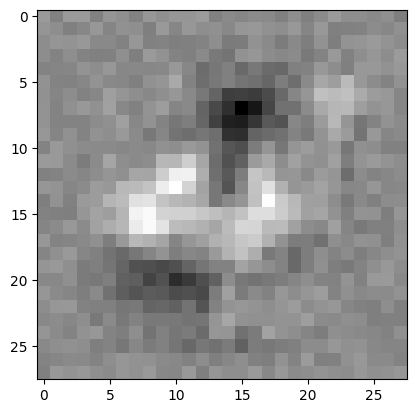

Epoch 72
Accuracy: 0.931
Losses: tensor(0.3110, grad_fn=<NllLossBackward0>)


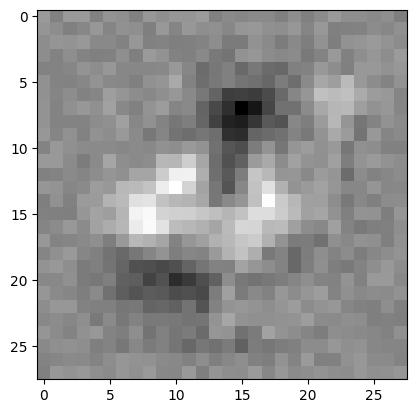

Epoch 73
Accuracy: 0.931
Losses: tensor(0.3090, grad_fn=<NllLossBackward0>)


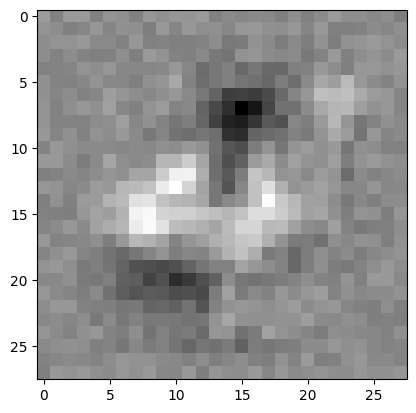

Epoch 74
Accuracy: 0.931
Losses: tensor(0.3070, grad_fn=<NllLossBackward0>)


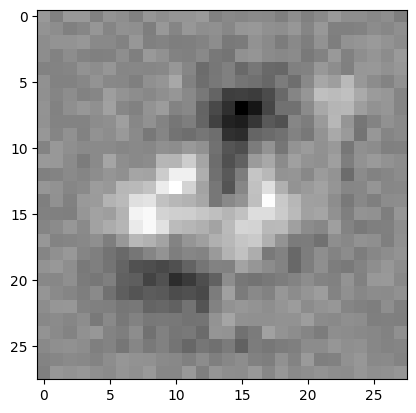

Epoch 75
Accuracy: 0.931
Losses: tensor(0.3051, grad_fn=<NllLossBackward0>)


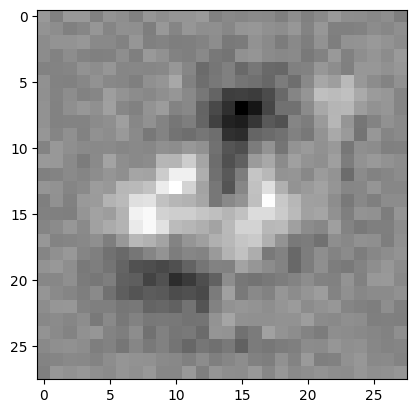

Epoch 76
Accuracy: 0.931
Losses: tensor(0.3032, grad_fn=<NllLossBackward0>)


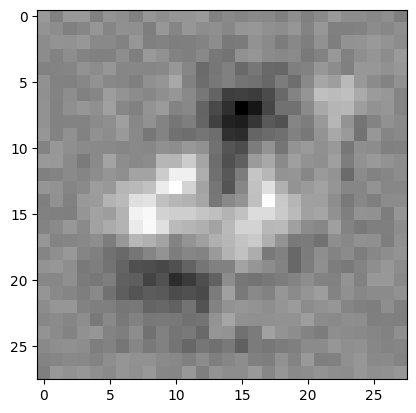

Epoch 77
Accuracy: 0.931
Losses: tensor(0.3013, grad_fn=<NllLossBackward0>)


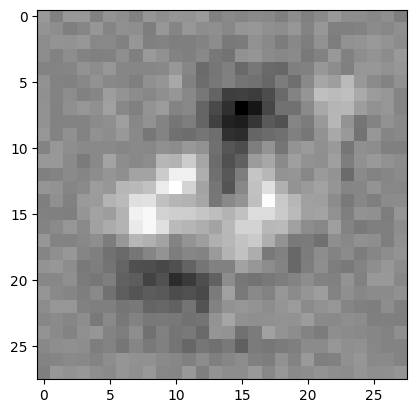

Epoch 78
Accuracy: 0.933
Losses: tensor(0.2995, grad_fn=<NllLossBackward0>)


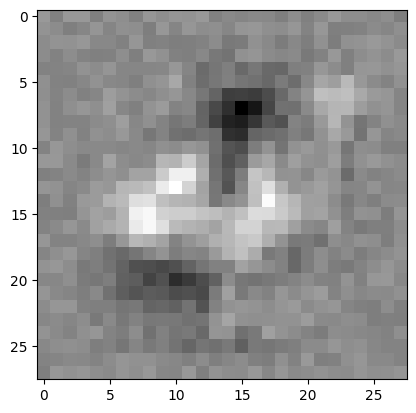

Epoch 79
Accuracy: 0.934
Losses: tensor(0.2977, grad_fn=<NllLossBackward0>)


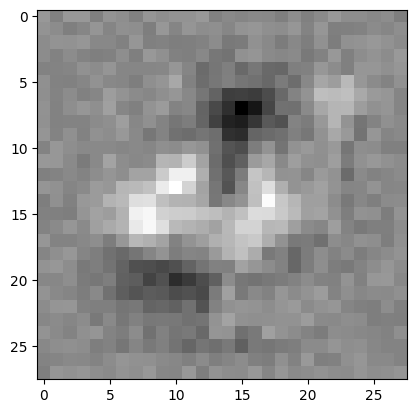

Epoch 80
Accuracy: 0.934
Losses: tensor(0.2959, grad_fn=<NllLossBackward0>)


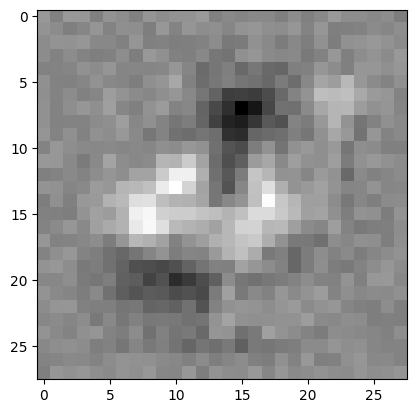

Epoch 81
Accuracy: 0.935
Losses: tensor(0.2942, grad_fn=<NllLossBackward0>)


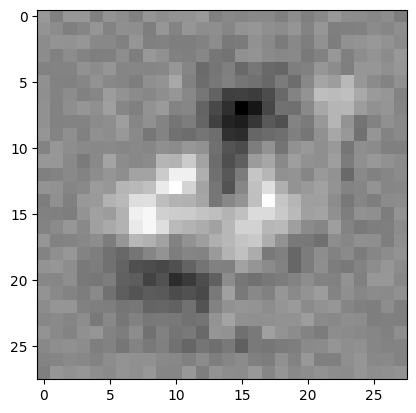

Epoch 82
Accuracy: 0.935
Losses: tensor(0.2925, grad_fn=<NllLossBackward0>)


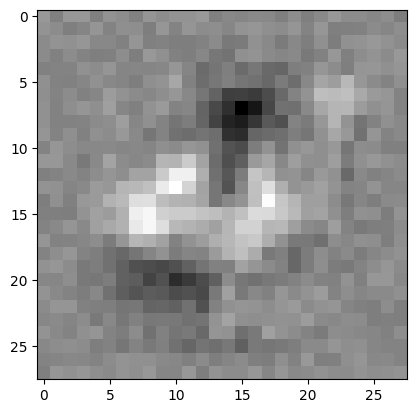

Epoch 83
Accuracy: 0.935
Losses: tensor(0.2908, grad_fn=<NllLossBackward0>)


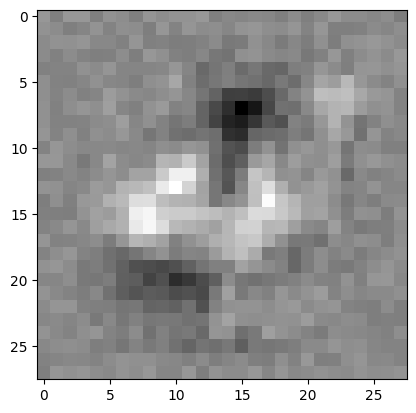

Epoch 84
Accuracy: 0.935
Losses: tensor(0.2891, grad_fn=<NllLossBackward0>)


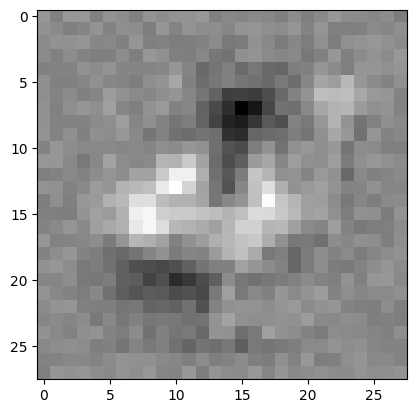

Epoch 85
Accuracy: 0.935
Losses: tensor(0.2875, grad_fn=<NllLossBackward0>)


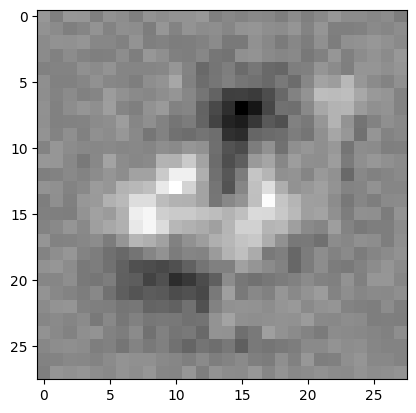

Epoch 86
Accuracy: 0.935
Losses: tensor(0.2858, grad_fn=<NllLossBackward0>)


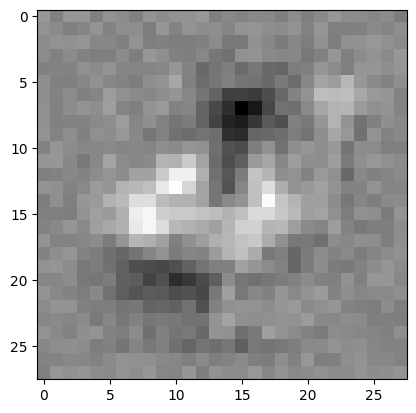

Epoch 87
Accuracy: 0.937
Losses: tensor(0.2842, grad_fn=<NllLossBackward0>)


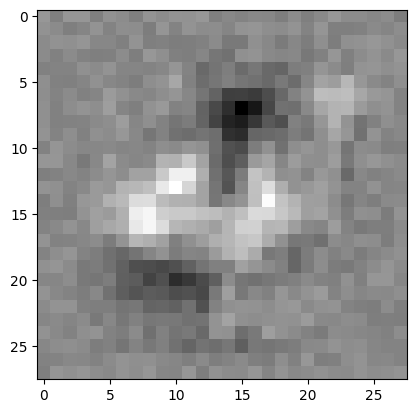

Epoch 88
Accuracy: 0.937
Losses: tensor(0.2827, grad_fn=<NllLossBackward0>)


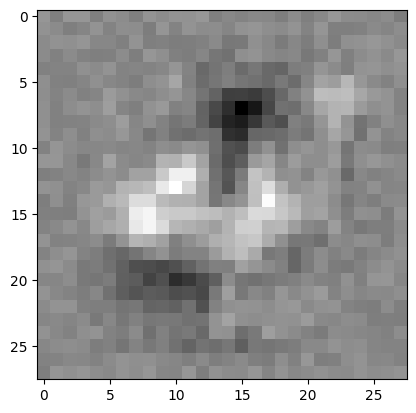

Epoch 89
Accuracy: 0.938
Losses: tensor(0.2811, grad_fn=<NllLossBackward0>)


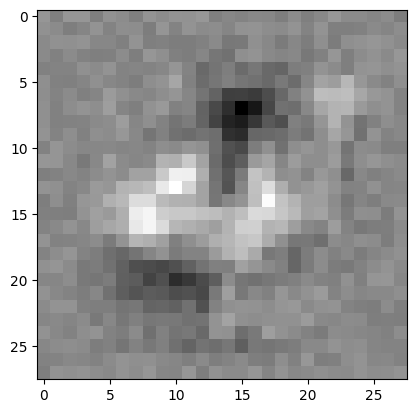

Epoch 90
Accuracy: 0.938
Losses: tensor(0.2796, grad_fn=<NllLossBackward0>)


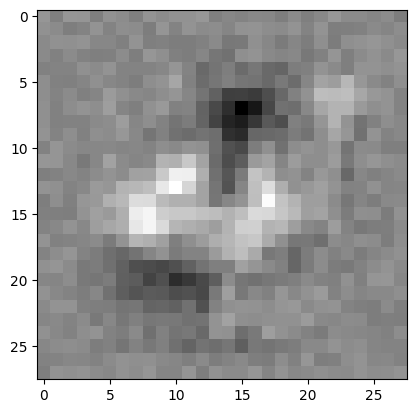

Epoch 91
Accuracy: 0.938
Losses: tensor(0.2781, grad_fn=<NllLossBackward0>)


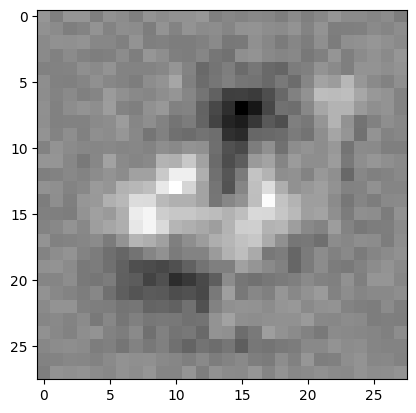

Epoch 92
Accuracy: 0.938
Losses: tensor(0.2766, grad_fn=<NllLossBackward0>)


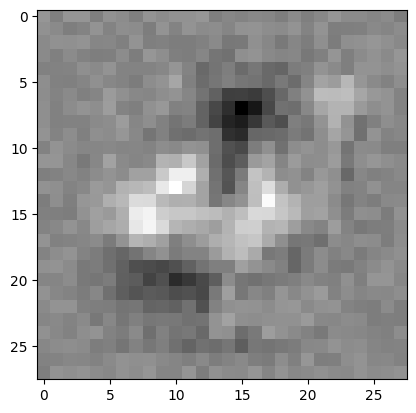

Epoch 93
Accuracy: 0.938
Losses: tensor(0.2751, grad_fn=<NllLossBackward0>)


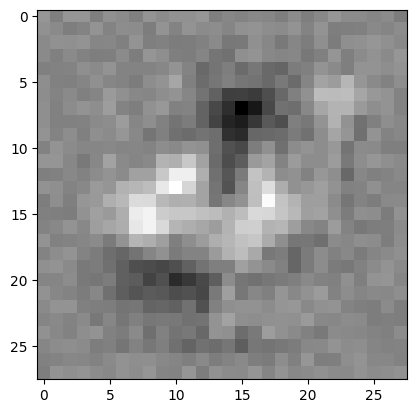

Epoch 94
Accuracy: 0.939
Losses: tensor(0.2736, grad_fn=<NllLossBackward0>)


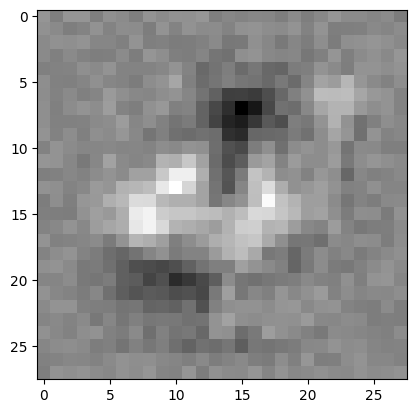

Epoch 95
Accuracy: 0.939
Losses: tensor(0.2722, grad_fn=<NllLossBackward0>)


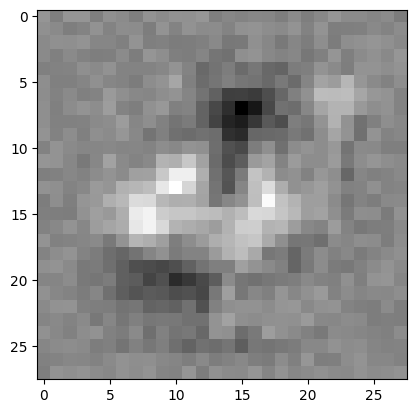

Epoch 96
Accuracy: 0.939
Losses: tensor(0.2708, grad_fn=<NllLossBackward0>)


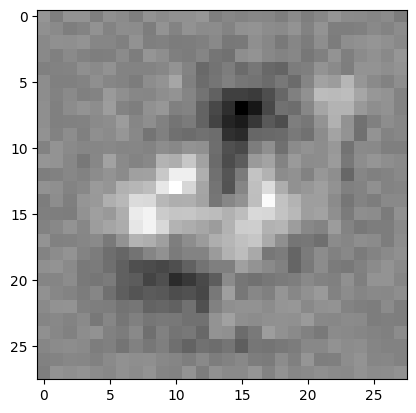

Epoch 97
Accuracy: 0.94
Losses: tensor(0.2694, grad_fn=<NllLossBackward0>)


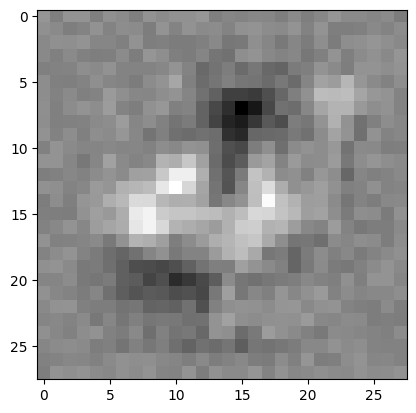

Epoch 98
Accuracy: 0.941
Losses: tensor(0.2680, grad_fn=<NllLossBackward0>)


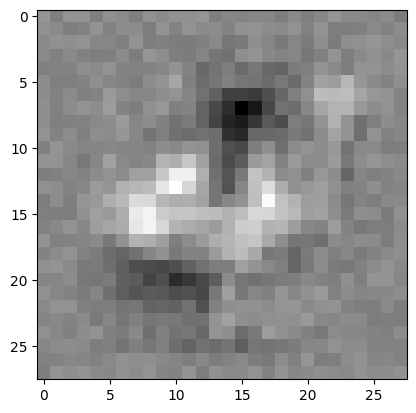

Epoch 99
Accuracy: 0.942
Losses: tensor(0.2667, grad_fn=<NllLossBackward0>)


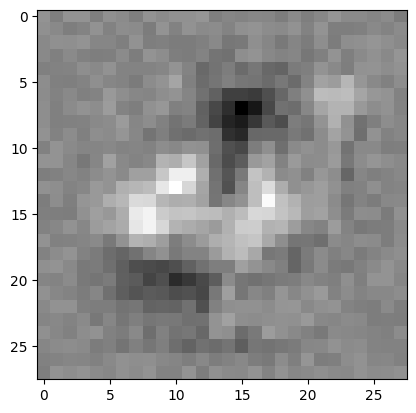

Epoch 100
Accuracy: 0.942
Losses: tensor(0.2653, grad_fn=<NllLossBackward0>)


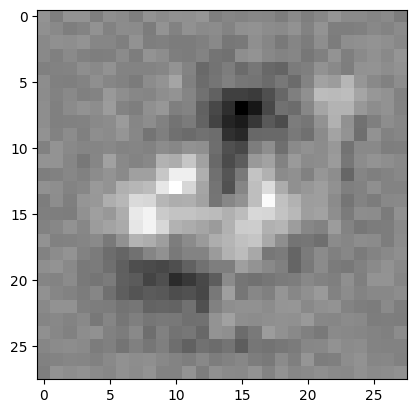

In [61]:
losses = []
import numpy

import numpy
import torch.nn.functional as F
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    out_softmax = F.softmax(outputs,dim=1)
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print("Epoch " + str(i + 1))
    print("Accuracy: " + str(accuracy))
    print("Losses: " + str(loss))
    weights = model.state_dict()['weight']
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

In [50]:
print('Final loss:', loss.item())

Final loss: 0.26510295271873474


### Visualizando gráfico de perda durante o treinamento

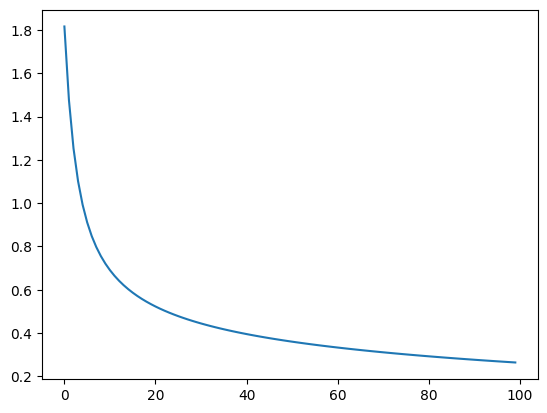

In [25]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [26]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.943


### Matriz de confusão com dados de treinamento e teste

In [27]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,2,0,0,0,2,2,1,0
2,0,1,90,1,0,1,0,1,1,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,0,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,91,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,83,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


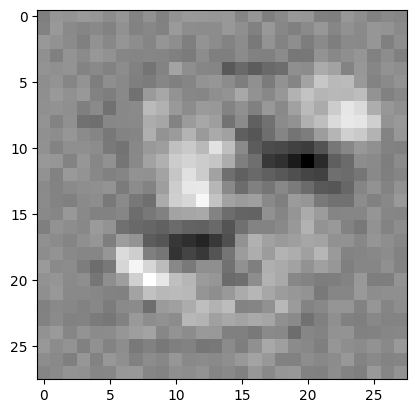

In [31]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[5, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

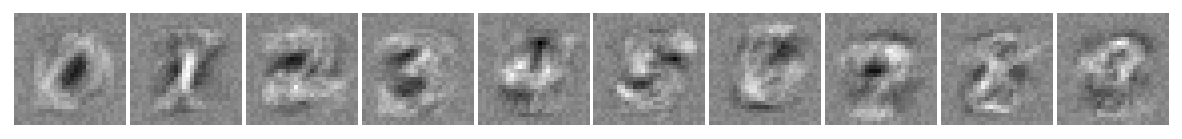

In [32]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_hat, após o softmax, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

In [52]:
print(torch.max(out_softmax[9]))

tensor(0.9741, grad_fn=<MaxBackward1>)


- 2) Insira código no laço do treinamento para que no final de cada época, 
     seja impresso: o número da época e a perda e a acurácia

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

- 3) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

## Perguntas

1. Qual é o shape da matriz de entrada na rede?

R.: [1000, 28x28]

2. Qual é o shape da saída da rede?

R.:[1000, 10]

3. Qual é o número total de parâmetros da rede, incluindo o bias?

R.: (28x28 + 1) * 10

# Aprendizados
